# Overview

Here goal is to load the model and give an image to classify it, that is the only task

In [1]:
from open_flamingo import create_model_and_transforms

model, image_processor, tokenizer = create_model_and_transforms(
    clip_vision_encoder_path="ViT-L-14",
    clip_vision_encoder_pretrained="openai",
    lang_encoder_path="anas-awadalla/mpt-1b-redpajama-200b",
    tokenizer_path="anas-awadalla/mpt-1b-redpajama-200b",
    cross_attn_every_n_layers=1,
    # cache_dir="/scratch/workspace/asureddy_umass_edu-llm_alignment/hf-cache"  # Defaults to ~/.cache
)

/project/pi_hongyu_umass_edu/zonghai/clinical-llm-alignment/durga_sandeep/custom_envs/icl/lib/python3.9/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
A new version of the following files was downloaded from https://huggingface.co/anas-awadalla/mpt-1b-redpajama-200b:
- configuration_mosaic_gpt.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/anas-awadalla/mpt-1b-redpajama-200b:
- mosaic_gpt.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/project/pi_hongyu_umass_edu/zonghai/clinical-llm-alignment/durga_sandeep/custom_envs/icl/lib/python3.9/site-packages/torchvision/da

You are using config.init_device='cpu', but you can also use config.init_device="meta" with Composer + FSDP for fast initialization.
Flamingo model initialized with 1046992944 trainable parameters


In [2]:
# grab model checkpoint from huggingface hub
from huggingface_hub import hf_hub_download
import torch

checkpoint_path = hf_hub_download("openflamingo/OpenFlamingo-3B-vitl-mpt1b", "checkpoint.pt")
model.load_state_dict(torch.load(checkpoint_path), strict=False)
model.to("cuda")

Flamingo(
  (vision_encoder): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-23): 24 x ResidualAttentionBlock(
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((1024,), eps=1e-05, elementwis

### Imagenet Data

In [3]:
from PIL import Image
import random
import os

with open("/project/pi_hongyu_umass_edu/zonghai/clinical-llm-alignment/durga_sandeep/icl-on-VLMs/flamingo/classification/imagenet/LOC_synset_mapping.txt", 'r') as f:
    mapping = f.readlines()
file_to_label_dict = {x.split(" ")[0] : (" ".join(x.replace("\n", "").lower().split(" ")[1:])).split(", ") for x in mapping}

all_val_files = os.listdir("/scratch/workspace/dsaluru_umass_edu-email/imagenet/imagenet/val/")
len(all_val_files)

1000

In [4]:
def get_random_image_and_label(verbose=True):
    val_dir = "/scratch/workspace/dsaluru_umass_edu-email/imagenet/imagenet/val/"
    folder_name = random.sample(all_val_files,1)
    file_name = random.sample(os.listdir(f"{val_dir}{folder_name[0]}/"), 1)

    im1 = f"{val_dir}{folder_name[0]}/{file_name[0]}"
    demo_image = Image.open(im1)
    label = file_to_label_dict[folder_name[0]]
    if verbose:
        print("Label : ", file_to_label_dict[folder_name[0]])
    return demo_image, label

In [38]:
import torch
def inference(demo_images, query, max_new_tokens=20, verbose=True):
    """
    Step 2: Preprocessing images
    Details: For OpenFlamingo, we expect the image to be a torch tensor of shape 
    batch_size x num_media x num_frames x channels x height x width. 
    In this case batch_size = 1, num_media = 3, num_frames = 1,
    channels = 3, height = 224, width = 224.
    """
    vision_x = []

    for img in demo_images:
        vision_x.append(image_processor(img).unsqueeze(0))

    vision_x = torch.cat(vision_x, dim=0)
    vision_x = vision_x.unsqueeze(1).unsqueeze(0)
    
    """
    Step 3: Preprocessing text
    Details: In the text we expect an <image> special token to indicate where an image is.
    We also expect an <|endofchunk|> special token to indicate the end of the text 
    portion associated with an image.
    """
    tokenizer.padding_side = "left" # For generation padding tokens should be on the left
    lang_x = tokenizer(
        [query],
        return_tensors="pt",
    )

    """
    Step 4: Generate text
    """
    generated_text = model.generate(
        vision_x=vision_x.cuda(),
        lang_x=lang_x["input_ids"].cuda(),
        attention_mask=lang_x["attention_mask"].cuda(),
        max_new_tokens=max_new_tokens,
        num_beams=1,
    )
    torch.cuda.empty_cache()

    generated_text = tokenizer.decode(generated_text[0][len(lang_x["input_ids"][0]):])
    if verbose:
        print("### Generated text: ", generated_text)
    return generated_text


### Zero-shot sample

Label :  ['slug']


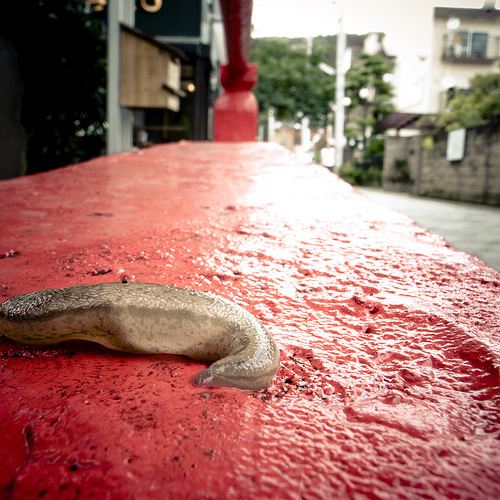

In [18]:
curr_demo_image, curr_label = get_random_image_and_label()
curr_demo_image

In [39]:
zero_shot_query = f"<image>\nQuestion: Classify the image into one of the imagenet1k label. Only give the class, no further explanation.\nAnswer:"
output = inference(demo_images=[curr_demo_image], query=zero_shot_query)
output

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


### Generated text:   The image is a slime mold.<|endofchunk|>


' The image is a slime mold.<|endofchunk|>'

In [23]:
print(output)


Question: Classify the image into one of the imagenet1k label. Only give the class, no further explanation.
Answer: The image is a slime mold.<|endofchunk|>


### One-Shot Sample

Label :  ['redbone']
Label :  ['giant schnauzer']


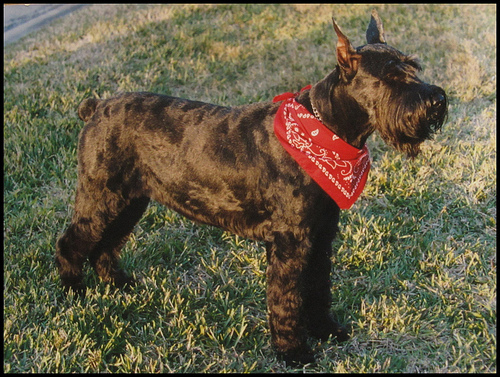

In [8]:
ex_demo_image, ex_label = get_random_image_and_label()
curr_demo_image, curr_label = get_random_image_and_label()
curr_demo_image

In [9]:
one_shot_query = f"""<image>
Question: Classify the image into one of the imagenet1k label.
Answer: {ex_label[0]} |<endofchunk>| 

<image>
Question: Classify the image into one of the imagenet1k label.
Answer:"""
inference(demo_images=[ex_demo_image, curr_demo_image], query=one_shot_query, max_new_tokens=8)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated text:  <image>
Question: Classify the image into one of the imagenet1k label.
Answer: redbone |<endofchunk>| 

<image>
Question: Classify the image into one of the imagenet1k label.
Answer: redbone |<endofchunk>


'<image>\nQuestion: Classify the image into one of the imagenet1k label.\nAnswer: redbone |<endofchunk>| \n\n<image>\nQuestion: Classify the image into one of the imagenet1k label.\nAnswer: redbone |<endofchunk>'

### Batch Processing

In [10]:
import torch

def batch_inference_with_demos(batch_demo_images, queries, max_new_tokens=20, batch_size=32):
    """
    Perform batch inference where each sample has multiple demonstration images.
    
    Args:
        batch_demo_images: List[List[Image]], where outer list is batch_size and inner list contains demo images for each sample
        queries: List of query strings (should be length batch_size)
        max_new_tokens: Maximum number of tokens to generate
        batch_size: Size of the batch (default: 32)
    
    Returns:
        List of generated texts
    """
    assert len(batch_demo_images) == batch_size, f"Expected {batch_size} samples, got {len(batch_demo_images)}"
    assert len(queries) == batch_size, f"Expected {batch_size} queries, got {len(queries)}"
    
    # Get number of demo images per sample (assuming all samples have same number of demos)
    num_demos = len(batch_demo_images[0])
    
    # Step 1: Process all demo images for all samples in the batch
    vision_x = []
    
    # For each sample in the batch
    for sample_demos in batch_demo_images:
        sample_processed = []
        # Process each demo image for this sample
        for img in sample_demos:
            processed_img = image_processor(img).unsqueeze(0)  # [1, C, H, W]
            sample_processed.append(processed_img)
        
        # Stack all demo images for this sample
        sample_processed = torch.cat(sample_processed, dim=0)  # [num_demos, C, H, W]
        vision_x.append(sample_processed.unsqueeze(0))  # Add sample dimension
    
    # Stack all samples together
    vision_x = torch.cat(vision_x, dim=0)  # [batch_size, num_demos, C, H, W]
    
    # Add num_frames dimension
    # Final shape: [batch_size, num_media=num_demos, num_frames=1, C, H, W]
    vision_x = vision_x.unsqueeze(2)
    
    # Step 2: Process text
    tokenizer.padding_side = "left"
    lang_x = tokenizer(
        queries,
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    
    # Step 3: Generate text
    with torch.cuda.amp.autocast():
        generated_texts = model.generate(
            vision_x=vision_x.cuda(),
            lang_x=lang_x["input_ids"].cuda(),
            attention_mask=lang_x["attention_mask"].cuda(),
            max_new_tokens=max_new_tokens,
            num_beams=1,
            pad_token_id=tokenizer.pad_token_id,
            # batch_size=batch_size,
        )
    
    # Step 4: Decode generated texts
    decoded_texts = []
    for text in generated_texts:
        decoded_text = tokenizer.decode(text)
        decoded_texts.append(decoded_text)
    
    torch.cuda.empty_cache()
    
    return decoded_texts

In [11]:
batch_demo_images = []
queries = []
for i in range(256):

    ex_demo_image, ex_label = get_random_image_and_label(verbose=False)
    curr_demo_image, curr_label = get_random_image_and_label(verbose=False)
    batch_demo_images.append([ex_demo_image, curr_demo_image])

    one_shot_query = f"""<image>
    Question: Classify the image into one of the imagenet1k label.
    Answer: {ex_label[0]} |<endofchunk>| 

    <image>
    Question: Classify the image into one of the imagenet1k label.
    Answer:"""
    queries.append(one_shot_query)

In [13]:
# batch_inference_with_demos(batch_demo_images, queries, max_new_tokens=10, batch_size=256)

### Zero-Shot Performance
- seems bad - will do it later

### One-Shot Performance
1. All folder names
2. Pick 100 folders in random and fix it
3. In each folder, 10 images in random and fix it
4. Now we have 100*10 = 1k validation samples
    - For each sample, pick n folders different from this folder and pick 1 image from each of those folders
    - build the n-shot prompt with demo_images in order
    - run VLM model
    - save the raw output result

In [57]:
import os
val_dir = "/scratch/workspace/dsaluru_umass_edu-email/imagenet/imagenet/val"
random.seed(42)
all_folder_names = list(file_to_label_dict.keys())

final_folder_names = all_folder_names[:1000]
folder_to_files = {}
folder_to_other_folders = {}

for folder in final_folder_names:
    folder_dir = f"{val_dir}/{folder}/"
    other_folders = [x for x in final_folder_names if x != folder]
    folder_to_other_folders[folder] = other_folders
    all_folder_files = os.listdir(folder_dir)
    folder_to_files[folder] = random.sample(all_folder_files, 10)

In [ ]:
n_few_shot = 1
count = 0

test_set = []

for folder in final_folder_names:
    other_folders = folder_to_other_folders[folder]
    target_label = file_to_label_dict[folder]
    for idx in range(10):
        if count%500==0:
            print(count)
        random.seed(count)
        pick_n_folders = random.sample(other_folders, n_few_shot)
        pick_n_files = []
        pick_n_files_names = []
        for ele in pick_n_folders:
            ex_file_name = random.sample(os.listdir(f"{val_dir}/{ele}/"), 1)[0]
            ex_label = file_to_label_dict[ele]

            ex_image_path = f"{val_dir}/{ele}/{ex_file_name}"
            ex_demo_image = Image.open(ex_image_path)
            pick_n_files.append((ex_demo_image, ex_label))
            pick_n_files_names.append(ex_file_name)
        
        curr_demo_images = []
        few_shot_query =f""""""
        for k in range(n_few_shot):
            curr_demo_images.append(pick_n_files[k][0])
            few_shot_query += f"<image>\nQuestion: Classify the image into one of the imagenet1k label.\nAnswer: {pick_n_files[k][1]} |<endofchunk>|\n\n"
        
        
        # add test sample
        curr_image_path = f"{val_dir}/{folder}/{folder_to_files[folder][idx]}"
        curr_demo_image = Image.open(curr_image_path)
        curr_demo_images.append(curr_demo_image)
        few_shot_query += "<image>\nQuestion: Classify the image into one of the imagenet1k label.\nAnswer:"
        
        test_set.append([folder, target_label, folder_to_files[folder][idx], pick_n_folders, pick_n_files_names, few_shot_query])
        count += 1
count


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500


In [ ]:
import pandas as pd
test_df = pd.DataFrame(test_set, columns = ['folder', 'target_label', "filename", 'pick_n_folders', 'pick_n_files_names', 'few_shot_query'])
print(test_df.shape)
test_df.head(3)

In [ ]:
inference(demo_images=[ex_demo_image, curr_demo_image], query=one_shot_query, max_new_tokens=8)